In [1]:
# -------------------------------------------------------------------------------------------------------------------
# Course name - Exploratory data analysis
# Course code - DSC530
# Week 4 assignment
# Script name - Shekhar530Week4.ipynb
# Creator - Manish Shekhar
# Date created - Jan 2nd to Jan 6th
# -------------------------------------------------------------------------------------------------------------------

### Page 11 1-1 & 1-2 Reading, and cleaning the NSFG respondent and pregnancy data file

In [19]:
# [Manish] - Importing required libraries

import sys
import numpy as np
import thinkstats2
import matplotlib.pyplot as plt
import math
import statistics
import thinkplot

from collections import defaultdict



# [Manish] - Reading the data file (NSFG repondent data) and cleaning it
dct_file='/Users/mshekhar/Downloads/2002FemResp.dct'
dat_file='/Users/mshekhar/Downloads/2002FemResp.dat.gz'
dct = thinkstats2.ReadStataDct(dct_file)
df_resp = dct.ReadFixedWidth(dat_file, compression='gzip', nrows=None)


# [Manish] - Reading the data file (NSFG pregnancy data)
dct_file='/Users/mshekhar/Downloads/2002FemPreg.dct'
dat_file='/Users/mshekhar/Downloads/2002FemPreg.dat.gz'
dct = thinkstats2.ReadStataDct(dct_file)
df_preg = dct.ReadFixedWidth(dat_file, compression='gzip')


# [Manish] - User defined function to clean the pregnancy data 
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.
    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan
    
    

# [Manish]- cleaning the data in pregnancy file
CleanFemPreg(df_preg)

### 3-1 Show class size paradox using how many children in the family as use case.  Families with many children are more likely to appear in your sample, and families with no children have no chance to be in the sample.

In [6]:
# checking distinct data counts in NSFG respondent variable NUMKDHH. 
# numkdhh per codebook is - "NUMBER OF BIO/ADOPT/RELATED/LEGAL CHILDREN UNDER AGE 18 IN HOUSEHOLD"
df_resp['numkdhh'].value_counts()
# We can see that almost half of the families do not have any children or 
# do not have any children under 18 in the sample dataset

0    3563
1    1636
2    1500
3     666
4     196
5      82
Name: numkdhh, dtype: int64

In [7]:
# Creating pmf / probablity mass function using pmf constructor of thinkstats2 library
# pmf_actual represents 
pmf_actual = thinkstats2.Pmf(df_resp['numkdhh'])
pmf_actual

Pmf({0: 0.466178202276593, 1: 0.21405207379301322, 2: 0.19625801386889966, 3: 0.08713855815779145, 4: 0.025644380478869556, 5: 0.01072877142483318})

In [8]:
# Check if pmf (probability mass function) sums upto 1 and thus data is normalized.
pmf_actual.Total()

1.0

In [21]:
# print actual pmf mean
pmf_actual = thinkstats2.Pmf(pmf_actual, label='actual')
print('Mean of actual PMFs =', pmf_actual.Mean())

Mean of actual PMFs = 1.024205155043831


In [22]:
# Constructing the biased distribution that we would see if we surveyed the children and 
# asked them how many children under 18 (includingthemselves) are in their household.
# Compute the distribution as observed by children, where the probability associated with each family 
# is “biased” by the number of children in the family.
def BiasPmf(pmf, label):
    new_pmf = pmf.Copy(label=label)

    for x, p in pmf.Items():
        new_pmf.Mult(x, x)
        
    new_pmf.Normalize()
    return new_pmf

# For each group of number of children under 18, x, lets multiply the probability by x, the number of children 
# who observe that family size (number of children in fanily under 18 years of age). 
# The result is a new Pmf that represents the biased distribution.
biased_pmf = BiasPmf(pmf_actual, label='observed')
biased_pmf.Total()
biased_pmf
print('Mean of observed PMFs =', biased_pmf.Mean())

Mean of observed PMFs = 2.403679100664282


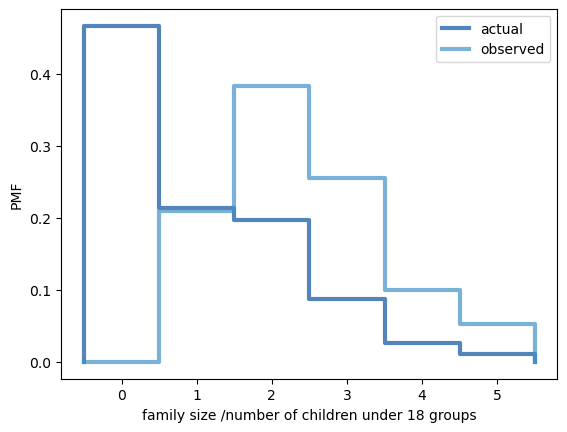

<Figure size 800x600 with 0 Axes>

In [23]:
# Plotting actual vs observed PMFs

thinkplot.PrePlot(2)
thinkplot.Pmfs([pmf_actual, biased_pmf])
thinkplot.Show(xlabel='family size /number of children under 18 groups', ylabel='PMF')

In [ ]:
# OBSERVATION 
# -----------
#  In the biased distribution there are fewer small family sizes / children groups under 18 and more large ones. 
# The mean of the biased distribution is 2.40, almost 150% higher than the actual mean.

### 3-2 Computing mean and variance from PMF

In [26]:
# Function to derive mean from PMF
# Function takes disctionary d as input with x as items and values as their corresponding pmfs
# Python dictionary keys are always unique and uniqueness check is not needed
def PmfMean(d):
    mean = 0
    for x, pmf in d.Items():
        mean = mean + (x*pmf)
        
    return mean


# Function to derive variance from PMF
# Function takes disctionary d as input with x as items and values as their corresponding pmfs
# Python dictionary keys are always unique and uniqueness check is not needed
def PmfVar(d):
    # call PmfMean to get the mean
    mean = PmfMean(d)
    var = 0
    
    for x, pmf in d.Items():
        var = var + pmf*((x - mean)**2)
        
    return var

In [27]:
# Test and validate PmfMean() function
# Using pmf_actual PMF representing number of children less than 18 years of age in the family.
print(PmfMean(pmf_actual))
print(pmf_actual.Mean())

1.024205155043831
1.024205155043831


In [28]:
# Test and validate PmfVar() function
# Using pmf_actual PMF representing number of children less than 18 years of age in the family.
print(PmfVar(pmf_actual))
print(pmf_actual.Var())

1.4128643263531195
1.4128643263531195


### 4-1 Compute percentile rank for your birth weight in live pregnancy dataset. Utilize first live pregnancy if you were first kid else utilize other live pregnancies dataset.

#### Using the code below from week 3 to create first live and all other live pregnancy datasets

In [30]:
# creating a data filter with live births as we are conserned with finding about first pregnancy tenure
filter_live_preg = df_preg['outcome']==1
filter_live_preg.value_counts()

True     9148
False    4445
Name: outcome, dtype: int64

In [31]:
# create a data frame with live births only
df_live_preg = df_preg[filter_live_preg]
df_live_preg['outcome'].value_counts()
# all pregnancies with outcome != 1 (live birth) are filtered out

1    9148
Name: outcome, dtype: int64

In [32]:
# creating the data two data frames 
# 1. first live pregnancies
# 2. all other (second to last) live pregnancies
filter_first_live_preg = df_live_preg['birthord']==1
df_first_live_preg = df_live_preg[filter_first_live_preg]
df_all_other_live_preg = df_live_preg[~filter_first_live_preg]

In [33]:
df_live_preg['prglngth'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of live pregnancies is 38.56 weeks

count    9148.000000
mean       38.560560
std         2.702344
min         0.000000
25%        39.000000
50%        39.000000
75%        39.000000
max        50.000000
Name: prglngth, dtype: float64

In [34]:
# check first live pregnancy data frame
df_first_live_preg.columns
df_first_live_preg['prglngth'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of first live pregnancies is 38.6 weeks

count    4413.000000
mean       38.600952
std         2.791901
min         0.000000
25%        39.000000
50%        39.000000
75%        40.000000
max        48.000000
Name: prglngth, dtype: float64

In [35]:
# check all other first live pregnancy data frame
df_all_other_live_preg.columns
df_all_other_live_preg['prglngth'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of first live pregnancies is 38.52 weeks

count    4735.000000
mean       38.522914
std         2.615852
min         4.000000
25%        39.000000
50%        39.000000
75%        39.000000
max        50.000000
Name: prglngth, dtype: float64

In [161]:
# Check summary stats of totalwgt_lb in first live pregnancy data frame
df_first_live_preg['totalwgt_lb'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of baby's total weight in case of first live pregnancies is 7.20 pounds

count    4363.000000
mean        7.201094
std         1.420573
min         0.125000
25%         6.437500
50%         7.312500
75%         8.000000
max        15.437500
Name: totalwgt_lb, dtype: float64

In [164]:
# Check summary stats of totalwgt_lb in all other live pregnancy data frame
df_all_other_live_preg['totalwgt_lb'].describe()
# We can see some summary stats i.e. mean, standard deviation, different percentiles etc
# Mean or average of baby's total weight in case of all other live pregnancies is 7.32 pounds

count    4675.000000
mean        7.325856
std         1.394195
min         0.562500
25%         6.500000
50%         7.375000
75%         8.187500
max        14.000000
Name: totalwgt_lb, dtype: float64

In [38]:
# My childhood birth in pounds was 6.2 pounds. Yeah pretty light baby. 
# I was second baby so I will look into all other live pregnancies daatset to determine my percentile rank.
# Calculating cdfs (cumulative distribution function) for toatl birthweight in all other live pregnancies.
other_cdf = thinkstats2.Cdf(df_all_other_live_preg['totalwgt_lb'], label='other')
# Use PercentileRank method of cdf object to get the percentile rank for my birth weight.
other_cdf.PercentileRank(6.2)
# As suspected I was pretty light at the time of birth. I guess I do not need to apologize to my mom :)

17.36898395721925

### 4-2 Are numbers generated by random.random have same probability of occurence?

In [39]:
# creating list of random 1000 numbers using random.random()
# import random 
from random import random
  
lst = []
 
for i in range(1000):
  lst.append(random())
   
# Prints random items
print(lst)

[0.06968392861144601, 0.6538085723772822, 0.7959030567549803, 0.5190874554371011, 0.13532292544015967, 0.6718959992324827, 0.4018012663796776, 0.7050041038653536, 0.543284648764944, 0.5980628453686979, 0.9164415998343963, 0.5433717416629638, 0.2365499486198851, 0.7795343554840652, 0.11180748793252437, 0.7920120357368338, 0.9219289241068301, 0.005224472718036388, 0.23485217272582837, 0.48949580011611205, 0.09009976227380623, 0.2506997776115444, 0.06923112114887509, 0.574016366591019, 0.25708305571601775, 0.49030911875651473, 0.8886845395452615, 0.49140656573766495, 0.21771822297917331, 0.6338245335483008, 0.44257691875473204, 0.07316449644712764, 0.8473599164599047, 0.1531907073063119, 0.23716409401948046, 0.5993439728986433, 0.0941681826890507, 0.7361817934109708, 0.10609660488405637, 0.4926230167166521, 0.4129923108269419, 0.42919783807049106, 0.8610264542533255, 0.14732206572069995, 0.33662902004960515, 0.9741270601303977, 0.4958108521504624, 0.34090903474485645, 0.720044157657705, 0

In [43]:
# Creating pmf for random numnbers
pmf_random = thinkstats2.Pmf(lst, label='pmf')
# Creating cdf for random nunbers
cdf_random = thinkstats2.Cdf(lst, label='cdf')

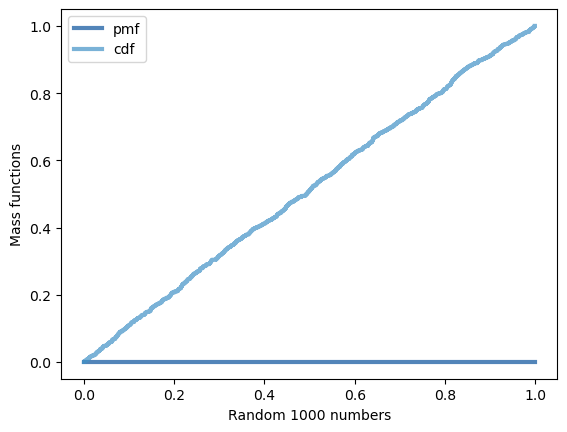

<Figure size 800x600 with 0 Axes>

In [44]:
# Plotting the pmf and cdf
thinkplot.PrePlot(2)
thinkplot.Cdfs([pmf_random, cdf_random])
thinkplot.Show(xlabel='Random 1000 numbers', ylabel='Mass functions')
# Clearly per figure below pmf line is straight continuous line between 0 and 1 and represents uniform distribution.
# CDF plot also shows cumulative straigh diagonal line from 0 to 1 and thus it represents a uniform ditribution.